In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import math
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import plotly.graph_objects as go
import plotly.offline as pyo
import streamlit as st
import dash
from dash import dcc, html, Input, Output
import warnings

warnings.filterwarnings("ignore")

In [2]:
mer_df = pd.read_csv('mergedstocktweet.csv')

In [3]:
mer_df.head()

ticker        date   adj_close       close        high         low  \
0   AMZN  08/01/2020   94.598503   94.598503   95.550003   94.321999   
1   MSFT  19/05/2020  177.436157  183.630005  186.600006  183.490005   
2   NVDA  09/04/2020   65.520805   65.737503   68.230003   65.105003   
3   NVDA  20/11/2020  130.544632  130.877502  134.945007  130.649994   
4   AMZN  01/05/2020  114.302002  114.302002  118.122002  112.909500   

         open     volume  prev_close_1  prev_close_2  prev_close_3  \
0   94.902000   70160000     95.343002     95.143997     93.748497   
1  185.029999   26799100    184.910004    183.160004    180.529999   
2   68.000000   52556400     66.737503     64.757500     67.099998   
3  134.539993   34108800    134.402496    134.287506    134.222504   
4  116.839996  195452000    123.699997    118.635498    115.704002   

   close_t_plus_1  close_t_plus_3  close_t_plus_7  daily_return        ma_5  \
0       95.052498       94.565002       93.236000     -0.007809   94.746899   
1      185.660004      183.509995      183.250000     -0.006922  182.396002   
2       67.462502       70.209999       67.377502     -0.014984   65.062001   
3      131.399994      132.347504      135.445007     -0.026227  133.788501   
4      115.799499      117.563003      117.847504     -0.075974  118.228301   

   sentiment  
0        NaN  
1        NaN  
2        NaN  
3   0.479733  
4   0.074767

In [4]:
mer_df.shape

(1235, 17)

In [5]:
mer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ticker          1235 non-null   object 
 1   date            1235 non-null   object 
 2   adj_close       1235 non-null   float64
 3   close           1235 non-null   float64
 4   high            1235 non-null   float64
 5   low             1235 non-null   float64
 6   open            1235 non-null   float64
 7   volume          1235 non-null   int64  
 8   prev_close_1    1230 non-null   float64
 9   prev_close_2    1225 non-null   float64
 10  prev_close_3    1220 non-null   float64
 11  close_t_plus_1  1235 non-null   float64
 12  close_t_plus_3  1235 non-null   float64
 13  close_t_plus_7  1235 non-null   float64
 14  daily_return    1230 non-null   float64
 15  ma_5            1235 non-null   float64
 16  sentiment       820 non-null    float64
dtypes: float64(14), int64(1), object(

In [6]:
mer_df.describe()

adj_close        close         high          low         open  \
count  1235.000000  1235.000000  1235.000000  1235.000000  1235.000000   
mean    120.352138   121.991374   123.929488   119.788716   121.886011   
std      48.751807    50.192909    50.656602    49.604321    50.210130   
min      24.081333    24.081333    26.990667    23.367332    24.980000   
25%      78.045811    79.778751    80.727501    78.983749    79.649998   
50%     118.410858   119.209999   120.970001   117.155502   118.738998   
75%     157.215500   158.244995   160.097244   156.288750   158.651505   
max     231.666672   231.666672   232.860001   227.350006   229.270004   

             volume  prev_close_1  prev_close_2  prev_close_3  close_t_plus_1  \
count  1.235000e+03   1230.000000   1225.000000   1220.000000     1235.000000   
mean   1.148069e+08    121.787216    121.574331    121.366054      122.357493   
std    9.704000e+07     50.126686     50.040669     49.972292       50.216471   
min    1.451220e+07     24.081333     24.081333     24.081333       24.081333   
25%    4.242200e+07     79.729378     79.712502     79.656252       79.954998   
50%    8.693980e+07    119.040001    118.980499    118.720001      119.489998   
75%    1.507010e+08    158.169746    158.128998    158.066246      158.387497   
max    9.140820e+08    231.666672    231.649994    231.649994      231.666672   

       close_t_plus_3  close_t_plus_7  daily_return         ma_5   sentiment  
count     1235.000000     1235.000000   1230.000000  1235.000000  820.000000  
mean       123.074900      124.557532      0.004209   121.263313    0.112107  
std         50.266860       50.443034      0.037125    50.014592    0.247491  
min         24.081333       24.081333     -0.210628    27.745067   -0.680800  
25%         80.519917       82.337502     -0.012154    79.251752    0.000000  
50%        120.511002      121.892502      0.003521   118.632402    0.094572  
75%        158.787750      159.431999      0.020653   157.822449    0.235805  
max        231.666672      235.223328      0.198949   227.988000    0.913600

In [7]:
mer_df.isnull().sum()

ticker              0
date                0
adj_close           0
close               0
high                0
low                 0
open                0
volume              0
prev_close_1        5
prev_close_2       10
prev_close_3       15
close_t_plus_1      0
close_t_plus_3      0
close_t_plus_7      0
daily_return        5
ma_5                0
sentiment         415
dtype: int64

In [8]:
mer_df['ticker'].value_counts()

ticker
AMZN    247
MSFT    247
NVDA    247
TSLA    247
AAPL    247
Name: count, dtype: int64

In [9]:
mer_df['date'] = pd.to_datetime(mer_df['date'], dayfirst=True)

In [10]:
mer_df = mer_df.sort_values(by=['ticker', 'date'])

In [11]:
mer_df = mer_df.dropna(subset=['prev_close_1', 'prev_close_2', 'prev_close_3', 'daily_return'])

In [12]:
mer_df['sentiment'] = mer_df['sentiment'].fillna(0.0)

In [13]:
mer_df['next_day_return'] = mer_df['close_t_plus_1'] - mer_df['adj_close']

In [14]:
mer_df['adj_next_day_return'] = (mer_df['close_t_plus_1'] - mer_df['adj_close']) / mer_df['adj_close']

In [15]:
mer_df.isnull().sum()

ticker                 0
date                   0
adj_close              0
close                  0
high                   0
low                    0
open                   0
volume                 0
prev_close_1           0
prev_close_2           0
prev_close_3           0
close_t_plus_1         0
close_t_plus_3         0
close_t_plus_7         0
daily_return           0
ma_5                   0
sentiment              0
next_day_return        0
adj_next_day_return    0
dtype: int64

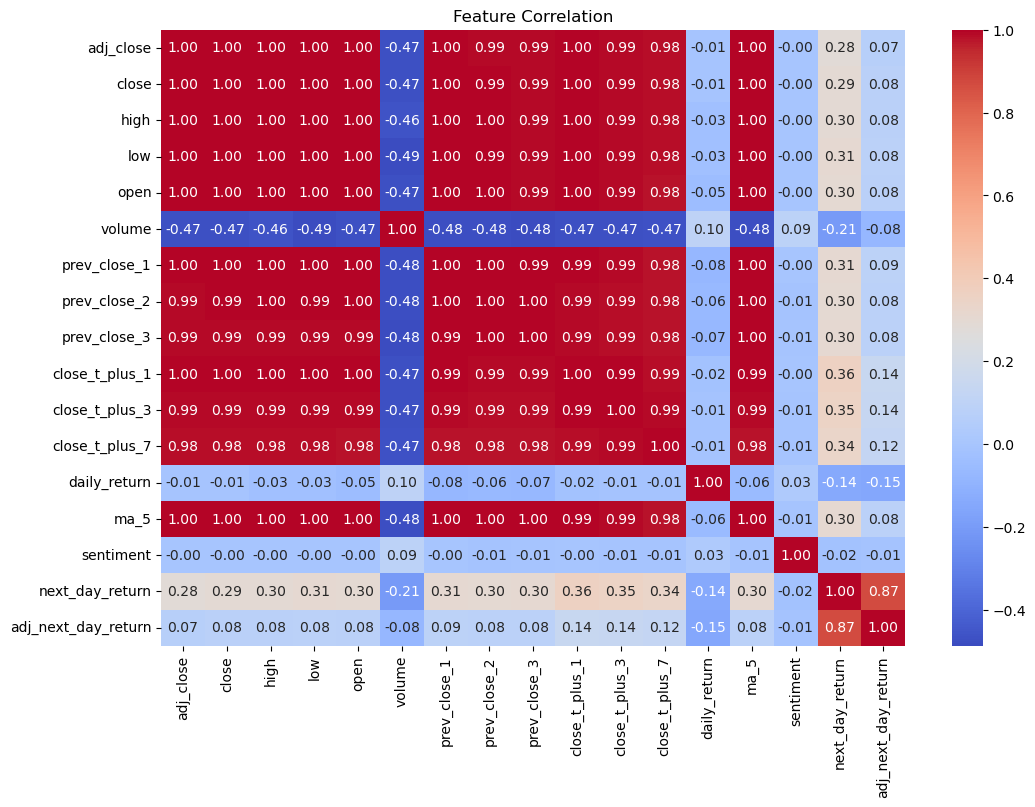

In [16]:
corr = mer_df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

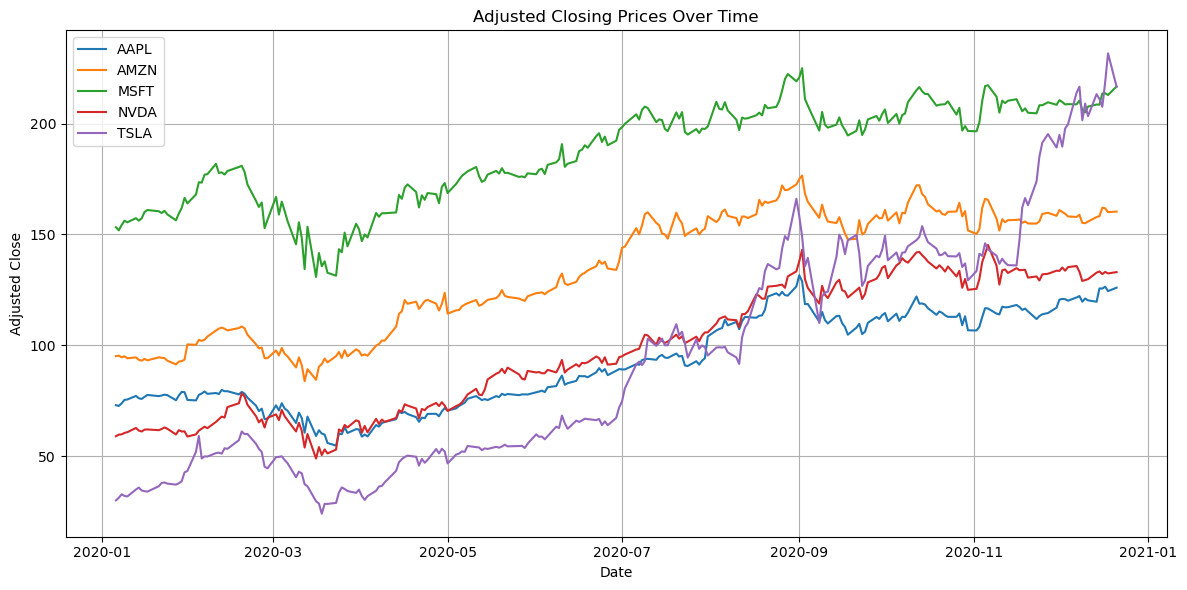

In [17]:
plt.figure(figsize=(12, 6))
for ticker in mer_df['ticker'].unique():
    subset = mer_df[mer_df['ticker'] == ticker]
    plt.plot(subset['date'], subset['adj_close'], label=ticker)
plt.legend()
plt.title('Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.grid(True)
plt.tight_layout()
plt.show()

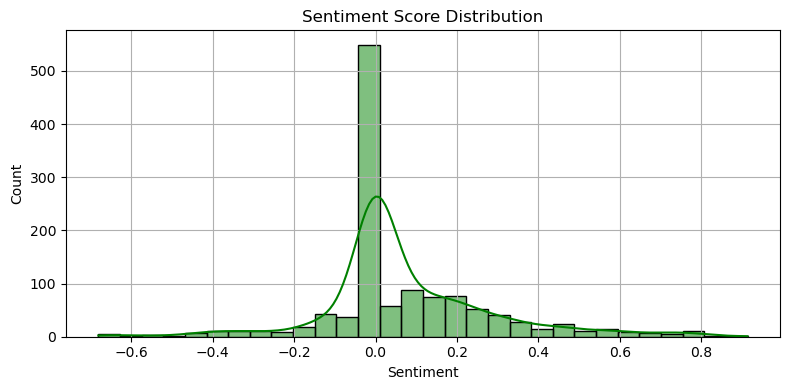

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(mer_df['sentiment'].dropna(), kde=True, bins=30, color='green')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()

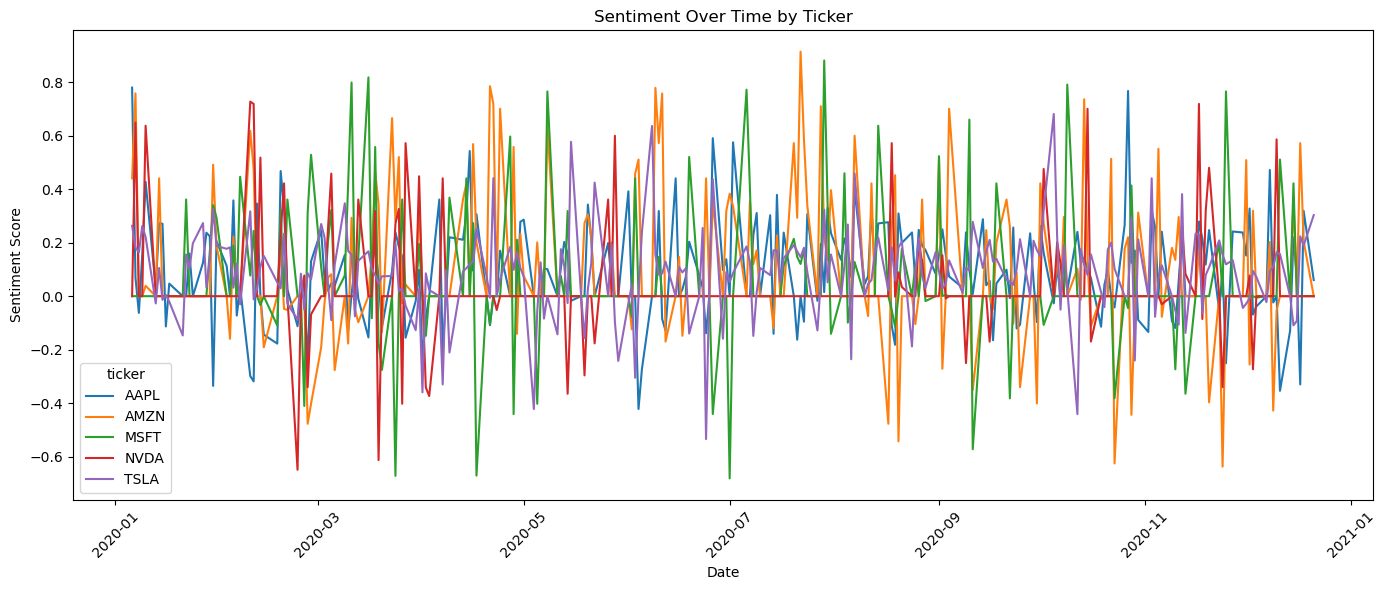

In [19]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=mer_df, x='date', y='sentiment', hue='ticker')
plt.title('Sentiment Over Time by Ticker')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

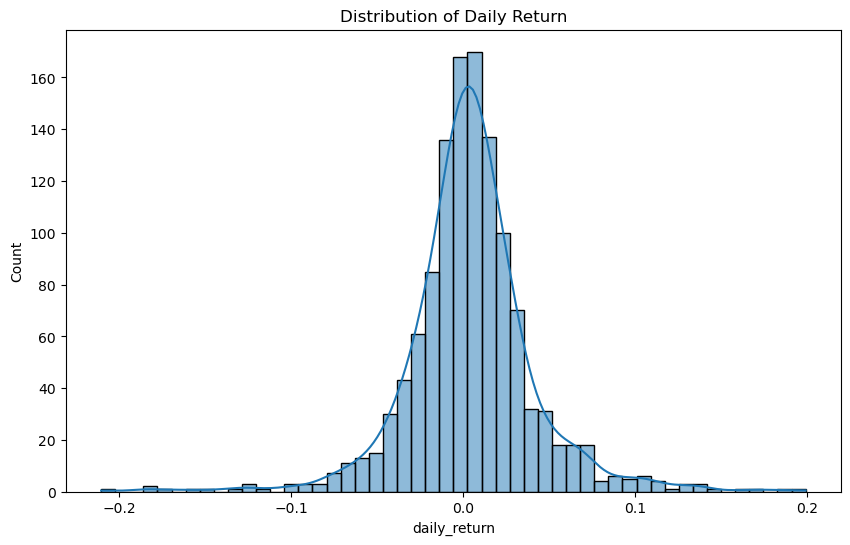

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(mer_df['daily_return'].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Return")
plt.show()

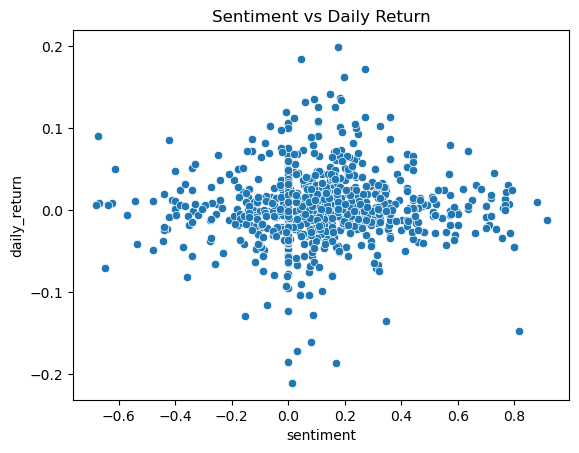

In [21]:
sns.scatterplot(data=mer_df, x='sentiment', y='daily_return')
plt.title("Sentiment vs Daily Return")
plt.show()

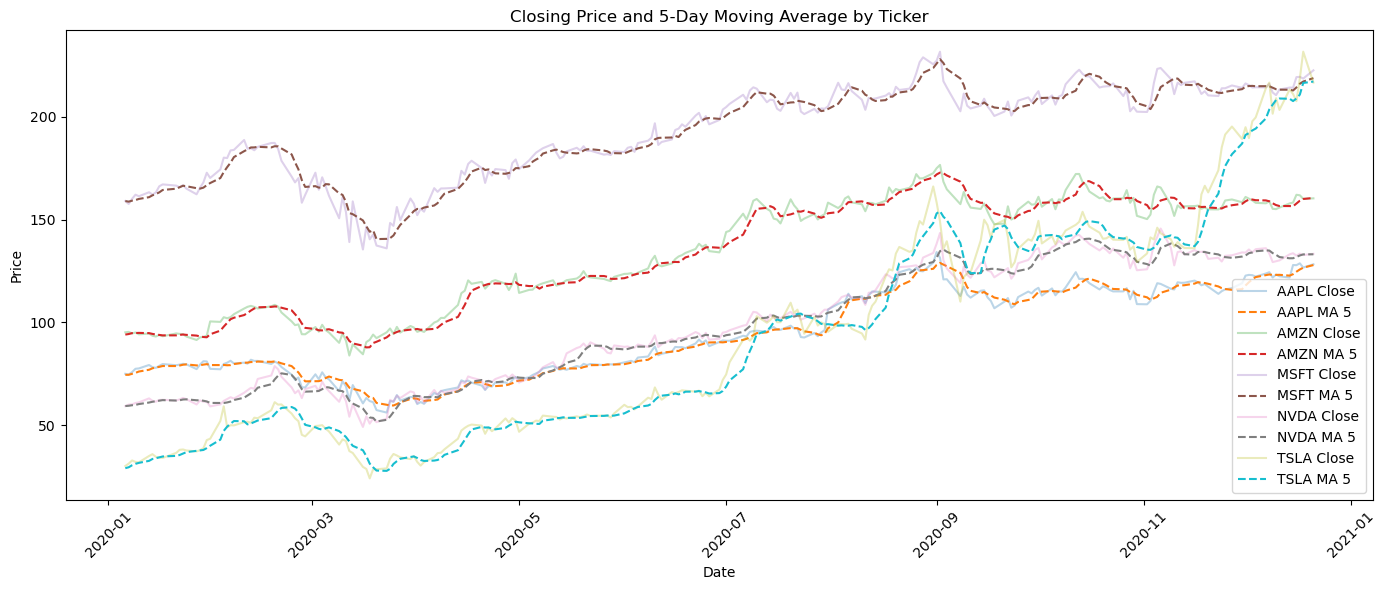

In [22]:
plt.figure(figsize=(14, 6))
for ticker in mer_df['ticker'].unique():
    df = mer_df[mer_df['ticker'] == ticker]
    plt.plot(df['date'], df['close'], label=f'{ticker} Close', alpha=0.3)
    plt.plot(df['date'], df['ma_5'], label=f'{ticker} MA 5', linestyle='--')
plt.title('Closing Price and 5-Day Moving Average by Ticker')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

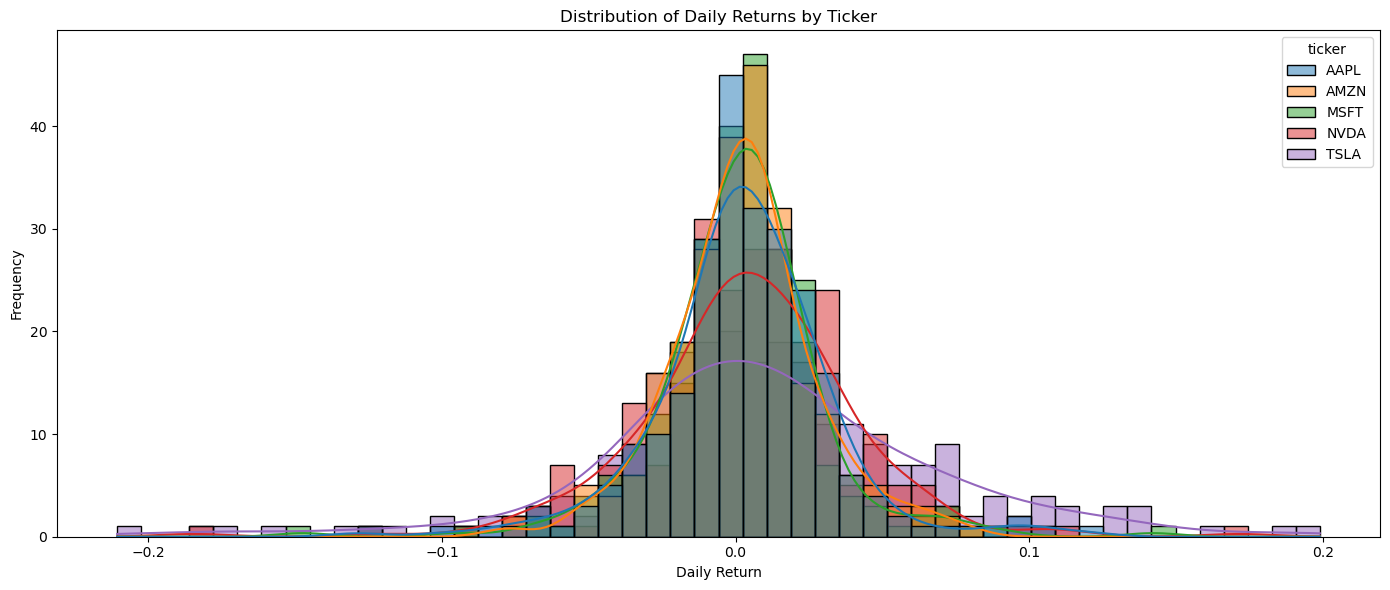

In [23]:
plt.figure(figsize=(14, 6))
sns.histplot(data=mer_df, x='daily_return', hue='ticker', kde=True, bins=50)
plt.title('Distribution of Daily Returns by Ticker')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [24]:
result = adfuller(df['adj_close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is NOT stationary (consider differencing)")

ADF Statistic: 0.47357674235330244
p-value: 0.9840474656566743
Series is NOT stationary (consider differencing)


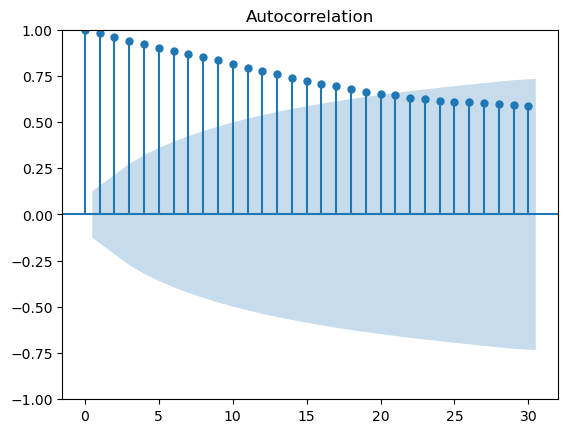

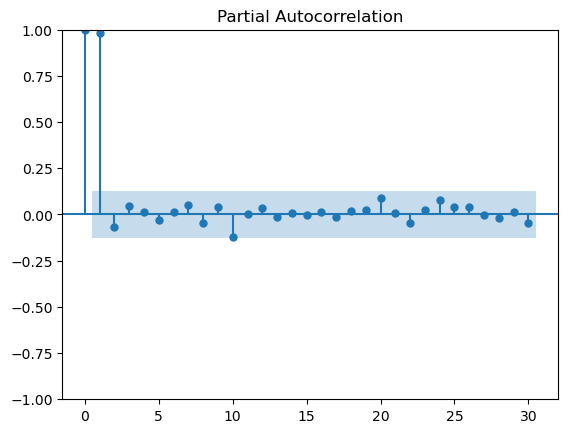

In [25]:
plot_acf(df['adj_close'].dropna(), lags=30)
plot_pacf(df['adj_close'].dropna(), lags=30)
plt.show()

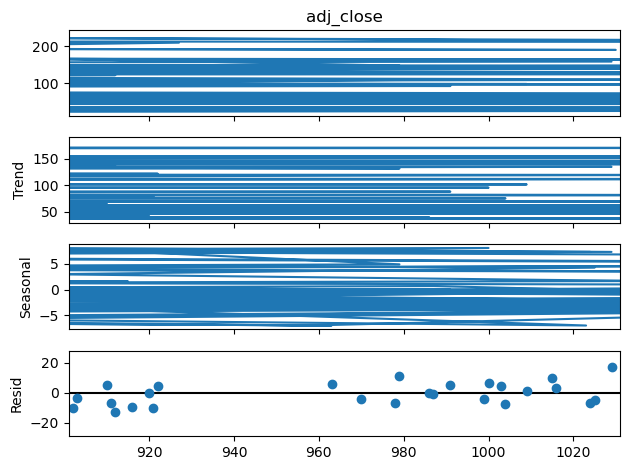

In [26]:
result = seasonal_decompose(df['adj_close'], model='additive', period=30)
result.plot()
plt.show()

In [27]:
df['adj_close_diff'] = df['adj_close'].diff()
result = adfuller(df['adj_close_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.19444736435052
p-value: 4.138317599970931e-29


In [28]:
df_model = df[['adj_close_diff', 'sentiment']].dropna()
model = SARIMAX(
    df_model['adj_close_diff'],
    exog=df_model[['sentiment']],
    order=(1, 0, 1)
)
results = model.fit(disp=False)
last_sentiment = df_model[['sentiment']].iloc[-1].values[0]
future_sentiment = pd.DataFrame({'sentiment': [last_sentiment]*7})

forecast_diff = results.get_forecast(steps=7, exog=future_sentiment)

last_adj_close = df['adj_close'].iloc[-1]
forecast_adj_close = last_adj_close + forecast_diff.predicted_mean.cumsum()

forecast_day_1 = forecast_adj_close.iloc[0]
forecast_day_3 = forecast_adj_close.iloc[2]
forecast_day_7 = forecast_adj_close.iloc[6]

print("Forecasted Adjusted Close Prices:")
print(f"Day 1: {forecast_day_1:.2f}")
print(f"Day 3: {forecast_day_3:.2f}")
print(f"Day 7: {forecast_day_7:.2f}")

Forecasted Adjusted Close Prices:
Day 1: 218.95
Day 3: 221.17
Day 7: 225.96


In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['adj_close'],
    mode='lines',
    name='Historical Adj Close'
))
forecast_dates = pd.date_range(start=df['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
fig.add_trace(go.Scatter(
    x=forecast_dates,
    y=forecast_adj_close.values,
    mode='markers+lines',
    name='Forecasted Adj Close'
))
fig.update_layout(
    title='Adjusted Close Price Forecast',
    xaxis_title='Date',
    yaxis_title='Adjusted Close Price',
    hovermode='x unified',
    width=1200,  
    height=500   
)

fig.show()

In [30]:
split_index = int(len(df_model) * 0.8)
train = df_model.iloc[:split_index]
test = df_model.iloc[split_index:]

model_eval = SARIMAX(
    train['adj_close_diff'],
    exog=train[['sentiment']],
    order=(1, 0, 1)
)
results_eval = model_eval.fit(disp=False)

forecast_diff_eval = results_eval.get_forecast(steps=len(test), exog=test[['sentiment']])
forecast_diff_mean_eval = forecast_diff_eval.predicted_mean

last_train_adj_close = df['adj_close'].iloc[split_index]
forecast_adj_close_eval = last_train_adj_close + forecast_diff_mean_eval.cumsum()

actual_adj_close_eval = df['adj_close'].iloc[split_index + 1 : split_index + 1 + len(test)]

mse = mean_squared_error(actual_adj_close_eval, forecast_adj_close_eval)
mae = mean_absolute_error(actual_adj_close_eval, forecast_adj_close_eval)
rmse = np.sqrt(mse)

print(f"Model Performance on Test Set:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Model Performance on Test Set:
MAE: 24.5044
MSE: 952.9549
RMSE: 30.8700


In [31]:
ticker = 'AMZN'
df_ticker = mer_df[mer_df['ticker'].str.strip().str.upper() == ticker]
print(f"Data for {ticker} contains {len(df_ticker)} records")

Data for AMZN contains 244 records


In [32]:
adf_result = adfuller(df_ticker['adj_close'].dropna())

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print("Series is NOT stationary, differencing needed.")
    df_ticker['adj_close_diff'] = df_ticker['adj_close'].diff()
else:
    print("Series is stationary.")
    df_ticker['adj_close_diff'] = df_ticker['adj_close']


ADF Statistic: -1.1244900835437595
p-value: 0.705207398868055
Series is NOT stationary, differencing needed.


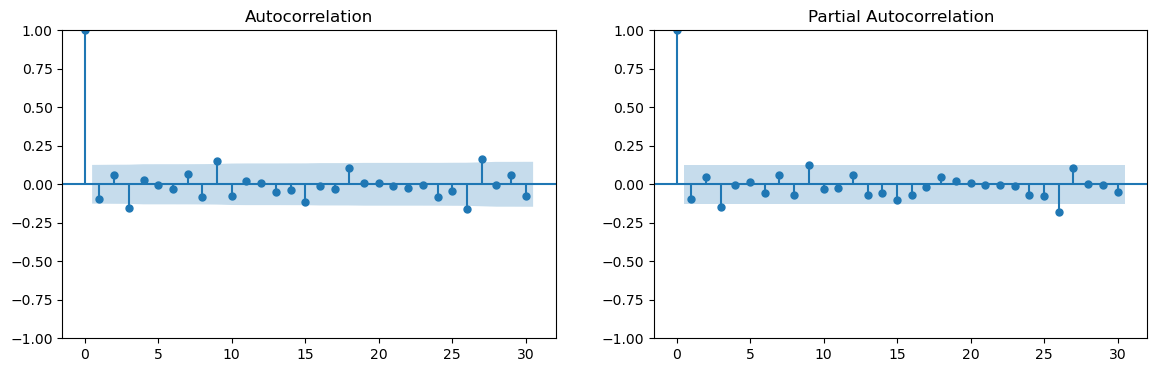

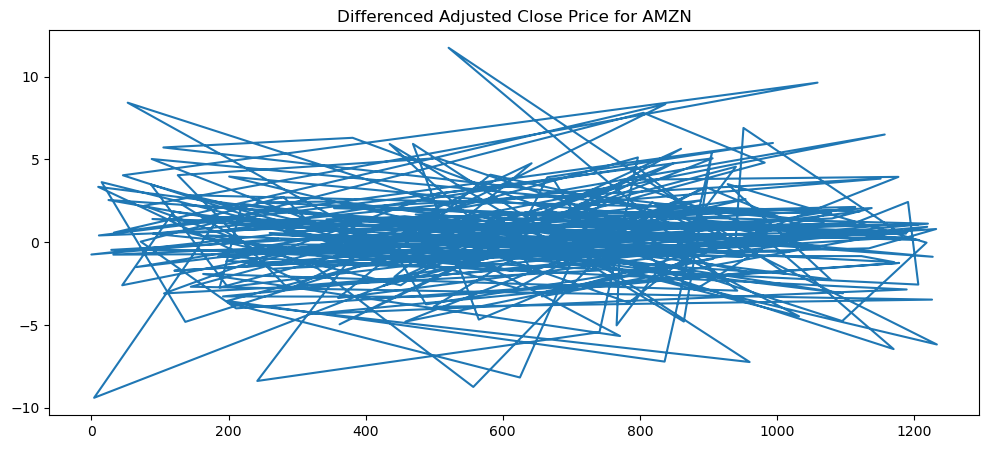

In [33]:
df_ticker_diff = df_ticker['adj_close_diff'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df_ticker_diff, lags=30, ax=axes[0])
plot_pacf(df_ticker_diff, lags=30, ax=axes[1])
plt.show()

df_ticker_diff.plot(title=f'Differenced Adjusted Close Price for {ticker}', figsize=(12, 5))
plt.show()

In [34]:
adf_result_diff = adfuller(df_ticker_diff)

print(f"ADF Statistic (after differencing): {adf_result_diff[0]}")
print(f"p-value (after differencing): {adf_result_diff[1]}")

if adf_result_diff[1] < 0.05:
    print("Series is stationary after differencing.")
else:
    print("Series is NOT stationary even after differencing.")

ADF Statistic (after differencing): -10.255477172778352
p-value (after differencing): 4.3727997704868226e-18
Series is stationary after differencing.


In [35]:
df_model = df_ticker[['date', 'adj_close_diff', 'sentiment']].dropna().copy()
model = SARIMAX(
    df_model['adj_close_diff'],
    exog=df_model[['sentiment']],
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

last_sentiment = df_model[['sentiment']].iloc[-1].values[0]
future_sentiment = pd.DataFrame({'sentiment': [last_sentiment] * 7})

forecast_diff = results.get_forecast(steps=7, exog=future_sentiment)

last_adj_close = df_ticker['adj_close'].iloc[-1]
forecast_adj_close = last_adj_close + forecast_diff.predicted_mean.cumsum()

forecast_day_1 = forecast_adj_close.iloc[0]
forecast_day_3 = forecast_adj_close.iloc[2]
forecast_day_7 = forecast_adj_close.iloc[6]

print(f"\n {ticker} Forecasted Adjusted Close Prices:")
print(f"Day 1: {forecast_day_1:.2f}")
print(f"Day 3: {forecast_day_3:.2f}")
print(f"Day 7: {forecast_day_7:.2f}")


 AMZN Forecasted Adjusted Close Prices:
Day 1: 160.27
Day 3: 160.28
Day 7: 160.28


In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_ticker['date'],
    y=df_ticker['adj_close'],
    mode='lines',
    name='Historical Adj Close',
    line=dict(color='blue')
))

forecast_dates = pd.date_range(start=df_ticker['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
fig.add_trace(go.Scatter(
    x=forecast_dates,
    y=forecast_adj_close,
    mode='lines+markers',
    name='Forecasted Adj Close',
    line=dict(color='orange')
))

fig.update_layout(
    title=f'{ticker} Adjusted Close Price Forecast (Interactive)',
    xaxis_title='Date',
    yaxis_title='Adjusted Close Price',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=1200,  
    height=600
)

fig.show()

In [37]:
df_model = df_ticker[['date', 'adj_close_diff', 'adj_close', 'sentiment']].dropna().copy()
split_index = int(len(df_model) * 0.8)
train = df_model.iloc[:split_index]
test = df_model.iloc[split_index:]

model_eval = SARIMAX(
    train['adj_close_diff'],
    exog=train[['sentiment']],
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_eval = model_eval.fit(disp=False)

forecast_diff_eval = results_eval.get_forecast(steps=len(test), exog=test[['sentiment']])
forecast_diff_mean_eval = forecast_diff_eval.predicted_mean

last_train_adj_close = df_model['adj_close'].iloc[split_index - 1]  
forecast_adj_close_eval = last_train_adj_close + forecast_diff_mean_eval.cumsum()

actual_adj_close_eval = df_model['adj_close'].iloc[split_index : split_index + len(test)]

mae = mean_absolute_error(actual_adj_close_eval, forecast_adj_close_eval)
mse = mean_squared_error(actual_adj_close_eval, forecast_adj_close_eval)
rmse = np.sqrt(mse)

print("Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Model Performance:
MAE: 14.3642
MSE: 225.9176
RMSE: 15.0306


In [38]:
ticker_msft = 'MSFT'
df_msft = mer_df[mer_df['ticker'].str.strip().str.upper() == ticker_msft]
print(f"Data for {ticker_msft} contains {len(df_msft)} records")

Data for MSFT contains 244 records


In [39]:
adf_result_msft = adfuller(df_msft['adj_close'].dropna())
print(f"ADF Statistic: {adf_result_msft[0]}")
print(f"p-value: {adf_result_msft[1]}")

if adf_result_msft[1] > 0.05:
    print("Series is NOT stationary, differencing needed.")
    df_msft['adj_close_diff'] = df_msft['adj_close'].diff()
else:
    print("Series is stationary.")
    df_msft['adj_close_diff'] = df_msft['adj_close']

ADF Statistic: -1.2321127446785192
p-value: 0.6596313638027943
Series is NOT stationary, differencing needed.


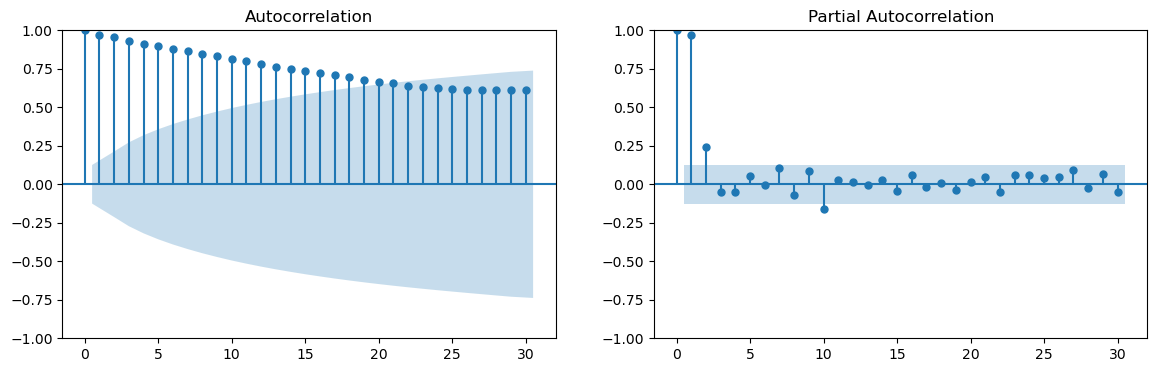

In [40]:
series = df_msft['adj_close'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(series, lags=30, ax=axes[0])
plot_pacf(series, lags=30, ax=axes[1])
plt.show()

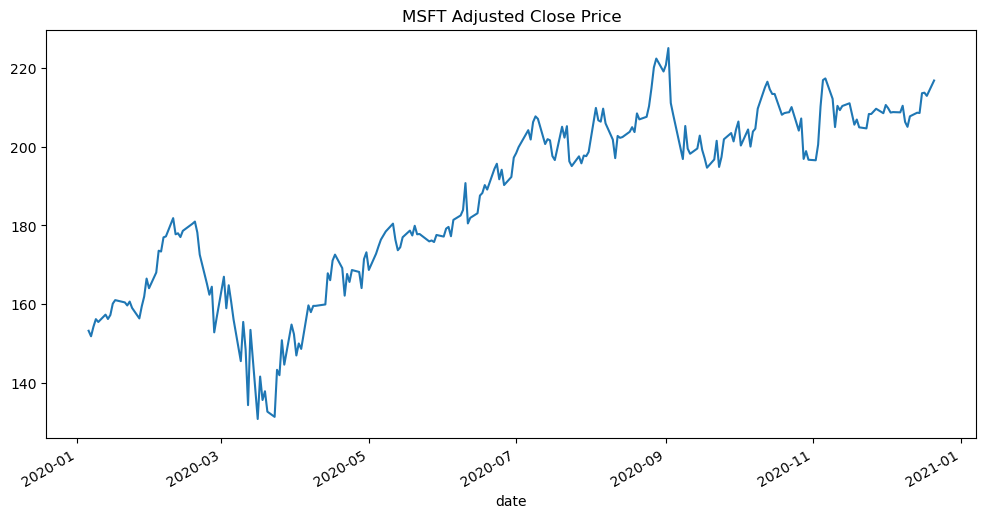

In [41]:
df_msft.set_index('date')['adj_close'].plot(figsize=(12,6), title='MSFT Adjusted Close Price')
plt.show()

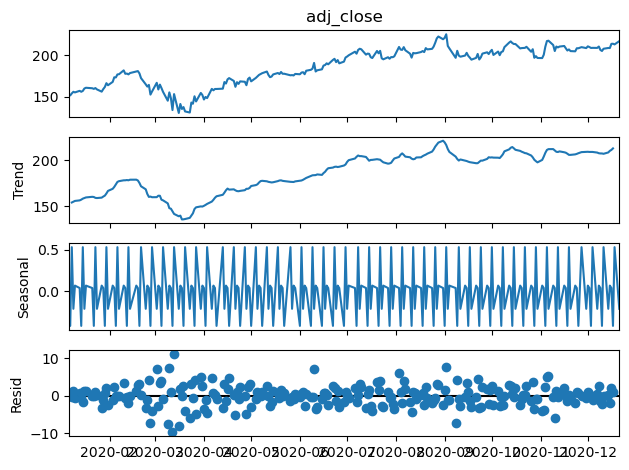

In [42]:
result = seasonal_decompose(df_msft.set_index('date')['adj_close'], model='additive', period=5)  
result.plot()
plt.show()

In [43]:
df_msft['adj_close_diff'] = df_msft['adj_close'].diff()

In [44]:
diff_series = df_msft['adj_close_diff'].dropna()
adf_result_diff = adfuller(diff_series)

print(f"ADF Statistic (differenced): {adf_result_diff[0]}")
print(f"p-value (differenced): {adf_result_diff[1]}")

if adf_result_diff[1] < 0.05:
    print("Series is stationary after differencing.")
else:
    print("Series is NOT stationary after differencing, consider further differencing or other transformations.")

ADF Statistic (differenced): -4.741891456284855
p-value (differenced): 7.015673466718059e-05
Series is stationary after differencing.


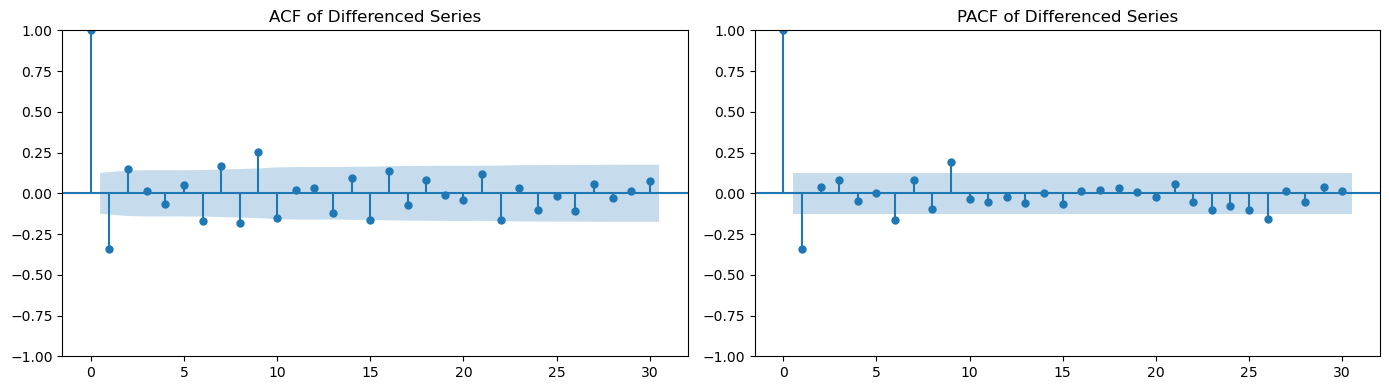

In [45]:
diff_series = df_msft['adj_close_diff'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(diff_series, lags=30, ax=axes[0])
axes[0].set_title('ACF of Differenced Series')

plot_pacf(diff_series, lags=30, ax=axes[1], method='ywm')
axes[1].set_title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

In [46]:
df_msft_model = df_msft[['date', 'adj_close_diff', 'sentiment']].dropna().copy()

In [47]:
model_msft = SARIMAX(
    df_msft_model['adj_close_diff'],
    exog=df_msft_model[['sentiment']],
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_msft = model_msft.fit(disp=False)

last_sentiment_msft = df_msft_model['sentiment'].iloc[-1]
future_sentiment_msft = pd.DataFrame({'sentiment': [last_sentiment_msft] * 7})

forecast_diff_msft = results_msft.get_forecast(steps=7, exog=future_sentiment_msft)
last_adj_close_msft = df_msft['adj_close'].iloc[-1]
forecast_adj_close_msft = last_adj_close_msft + forecast_diff_msft.predicted_mean.cumsum()

print(f"\nMSFT Forecasted Adjusted Close Prices:")
print(f"Day 1: {forecast_adj_close_msft.iloc[0]:.2f}")
print(f"Day 3: {forecast_adj_close_msft.iloc[2]:.2f}")
print(f"Day 7: {forecast_adj_close_msft.iloc[6]:.2f}")


MSFT Forecasted Adjusted Close Prices:
Day 1: 215.48
Day 3: 215.79
Day 7: 215.85


In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_msft['date'],
    y=df_msft['adj_close'],
    mode='lines',
    name='Historical Adj Close',
    line=dict(color='blue')
))

forecast_dates_msft = pd.date_range(start=df_msft['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)

fig.add_trace(go.Scatter(
    x=forecast_dates_msft,
    y=forecast_adj_close_msft,
    mode='lines+markers',
    name='Forecasted Adj Close',
    line=dict(color='orange')
))

fig.update_layout(
    title='MSFT Adjusted Close Price Forecast (Interactive)',
    xaxis_title='Date',
    yaxis_title='Adjusted Close Price',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=600,
    width=1200
)

fig.show()

In [49]:
df_msft_full = df_msft[['date', 'adj_close_diff', 'adj_close', 'sentiment']].dropna().copy()
split_idx = int(len(df_msft_full) * 0.8)
train = df_msft_full.iloc[:split_idx]
test = df_msft_full.iloc[split_idx:]

model_train = SARIMAX(
    train['adj_close_diff'],
    exog=train[['sentiment']],
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_train = model_train.fit(disp=False)
forecast_diff_test = results_train.get_forecast(steps=len(test), exog=test[['sentiment']])
forecast_diff_mean_test = forecast_diff_test.predicted_mean

last_train_adj_close = df_msft_full['adj_close'].iloc[split_idx - 1]
forecast_adj_close_test = last_train_adj_close + forecast_diff_mean_test.cumsum()

actual_adj_close_test = df_msft_full['adj_close'].iloc[split_idx: split_idx + len(test)]

mae = mean_absolute_error(actual_adj_close_test, forecast_adj_close_test)
mse = mean_squared_error(actual_adj_close_test, forecast_adj_close_test)
rmse = np.sqrt(mse)

print("Model Performance on Test Set for MSFT:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Model Performance on Test Set for MSFT:
MAE: 5.6607
MSE: 49.3423
RMSE: 7.0244


In [50]:
ticker_nvda = 'NVDA'
df_nvda = mer_df[mer_df['ticker'].str.strip().str.upper() == ticker_nvda]
print(f"Data for {ticker_nvda} contains {len(df_nvda)} records")

Data for NVDA contains 244 records


In [51]:
adf_result_nvda = adfuller(df_nvda['adj_close'].dropna())
print(f"ADF Statistic: {adf_result_nvda[0]}")
print(f"p-value: {adf_result_nvda[1]}")

if adf_result_nvda[1] > 0.05:
    print("Series is NOT stationary, differencing needed.")
    df_nvda['adj_close_diff'] = df_nvda['adj_close'].diff()
else:
    print("Series is stationary.")
    df_nvda['adj_close_diff'] = df_nvda['adj_close']


ADF Statistic: -0.8248560208801108
p-value: 0.8117115531838659
Series is NOT stationary, differencing needed.


In [52]:
series_nvda = df_nvda.set_index('date')['adj_close'].dropna()

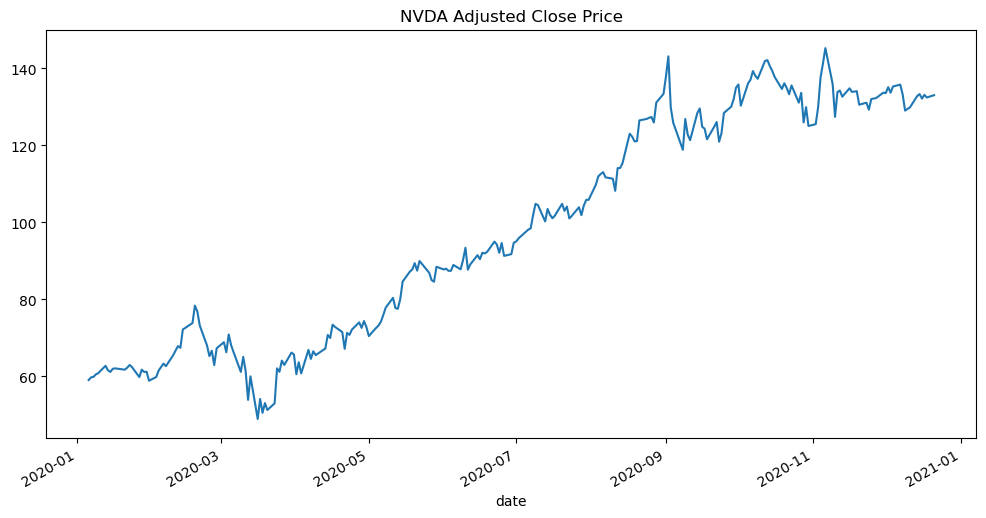

In [53]:
series_nvda.plot(title='NVDA Adjusted Close Price', figsize=(12,6))
plt.show()

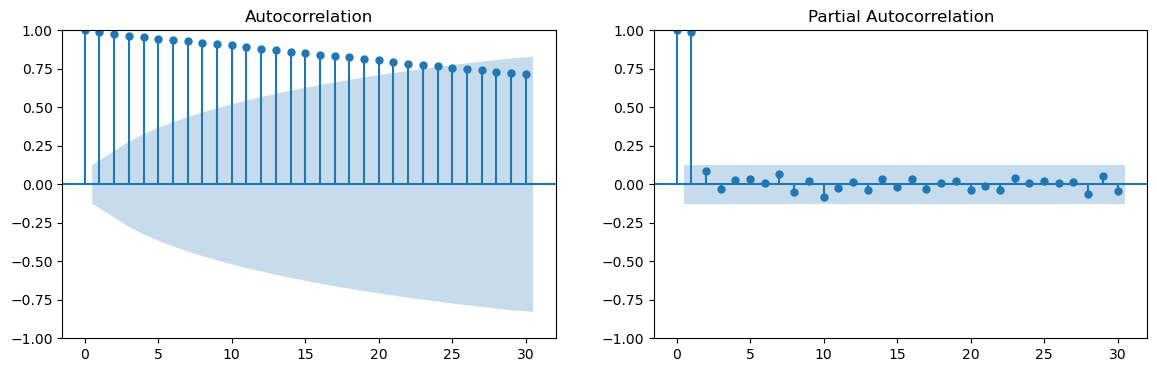

In [54]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
plot_acf(series_nvda, lags=30, ax=axes[0])
plot_pacf(series_nvda, lags=30, ax=axes[1])
plt.show()

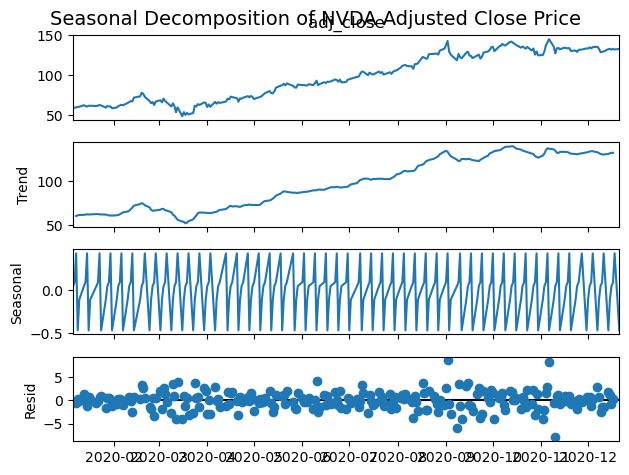

In [55]:
result = seasonal_decompose(series_nvda, model='additive', period=5)
result.plot()
plt.suptitle('Seasonal Decomposition of NVDA Adjusted Close Price', fontsize=14)
plt.show()

In [56]:
df_nvda['adj_close_diff'] = df_nvda['adj_close'].diff()

In [57]:
diff_series_nvda = df_nvda['adj_close_diff'].dropna()

In [58]:
adf_result_diff_nvda = adfuller(diff_series_nvda)
print(f"ADF Statistic (differenced): {adf_result_diff_nvda[0]}")
print(f"p-value (differenced): {adf_result_diff_nvda[1]}")

if adf_result_diff_nvda[1] < 0.05:
    print("Series is stationary after differencing.")
else:
    print("Series is still not stationary after differencing.")

ADF Statistic (differenced): -18.633198410900192
p-value (differenced): 2.0568027718345347e-30
Series is stationary after differencing.


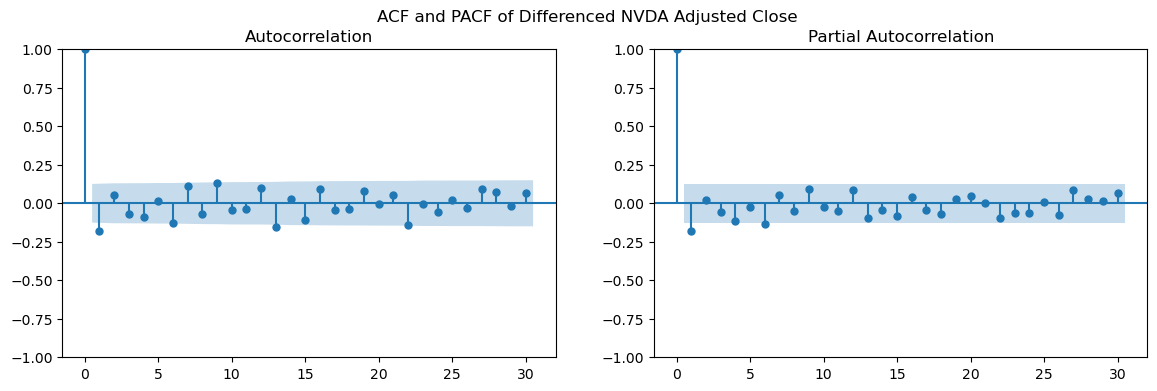

In [59]:
diff_series_nvda = df_nvda['adj_close_diff'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(diff_series_nvda, lags=30, ax=axes[0])
plot_pacf(diff_series_nvda, lags=30, ax=axes[1])
plt.suptitle('ACF and PACF of Differenced NVDA Adjusted Close')
plt.show()

In [60]:
df_nvda_model = df_nvda[['date', 'adj_close_diff', 'adj_close', 'sentiment']].dropna().copy()
split_idx = int(len(df_nvda_model) * 0.8)
train = df_nvda_model.iloc[:split_idx]
test = df_nvda_model.iloc[split_idx:]

model_train = SARIMAX(
    train['adj_close_diff'],
    exog=train[['sentiment']],
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_train = model_train.fit(disp=False)

In [61]:
forecast_diff_test = results_train.get_forecast(steps=len(test), exog=test[['sentiment']])
forecast_diff_mean_test = forecast_diff_test.predicted_mean

last_train_adj_close = df_nvda_model['adj_close'].iloc[split_idx - 1]
forecast_adj_close_test = last_train_adj_close + forecast_diff_mean_test.cumsum()

actual_adj_close_test = df_nvda_model['adj_close'].iloc[split_idx: split_idx + len(test)]
mae = mean_absolute_error(actual_adj_close_test, forecast_adj_close_test)
mse = mean_squared_error(actual_adj_close_test, forecast_adj_close_test)
rmse = np.sqrt(mse)

print("Model Performance on Test Set for NVDA:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Model Performance on Test Set for NVDA:
MAE: 9.2746
MSE: 101.2083
RMSE: 10.0602


In [62]:
last_sentiment_nvda = df_nvda_model['sentiment'].iloc[-1]
future_sentiment_nvda = pd.DataFrame({'sentiment': [last_sentiment_nvda] * 7})

forecast_diff_nvda = results_train.get_forecast(steps=7, exog=future_sentiment_nvda)
forecast_diff_mean_nvda = forecast_diff_nvda.predicted_mean
last_adj_close_nvda = df_nvda['adj_close'].iloc[-1]
forecast_adj_close_nvda = last_adj_close_nvda + forecast_diff_mean_nvda.cumsum()

day_1_forecast = forecast_adj_close_nvda.iloc[0]
day_3_forecast = forecast_adj_close_nvda.iloc[2]
day_7_forecast = forecast_adj_close_nvda.iloc[6]

print("\nNVDA Forecasted Adjusted Close Prices Based on Sentiment:")
print(f"Day 1: {day_1_forecast:.2f}")
print(f"Day 3: {day_3_forecast:.2f}")
print(f"Day 7: {day_7_forecast:.2f}")


NVDA Forecasted Adjusted Close Prices Based on Sentiment:
Day 1: 132.01
Day 3: 132.25
Day 7: 132.29


In [63]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_nvda['date'],
    y=df_nvda['adj_close'],
    mode='lines',
    name='Historical Adj Close',
    line=dict(color='blue')
))

forecast_dates_nvda = pd.date_range(start=df_nvda['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)

fig.add_trace(go.Scatter(
    x=forecast_dates_nvda,
    y=forecast_adj_close_nvda,
    mode='lines+markers',
    name='Forecasted Adj Close',
    line=dict(color='orange')
))

fig.update_layout(
    title='NVDA Adjusted Close Price Forecast',
    xaxis_title='Date',
    yaxis_title='Adjusted Close Price',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

In [64]:
selected_days = [0, 2, 6]
selected_dates = forecast_dates_nvda[selected_days]
selected_forecast = forecast_adj_close_nvda.iloc[selected_days]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_nvda['date'],
    y=df_nvda['adj_close'],
    mode='lines',
    name='Historical Adj Close',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=selected_dates,
    y=selected_forecast,
    mode='markers+lines',
    name='Forecasted Adj Close (Day 1, 3, 7)',
    line=dict(color='orange'),
    marker=dict(size=8)
))

fig.update_layout(
    title='NVDA Adjusted Close Price Forecast (Day 1, 3, 7 only)',
    xaxis_title='Date',
    yaxis_title='Adjusted Close Price',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=600,
    width=1200
)

fig.show()

In [65]:
ticker_tsla = 'TSLA'
df_tsla = mer_df[mer_df['ticker'].str.strip().str.upper() == ticker_tsla].copy()
print(f"Data for {ticker_tsla} contains {len(df_tsla)} records")

Data for TSLA contains 244 records


In [66]:
adf_result_tsla = adfuller(df_tsla['adj_close'].dropna())
print(f"ADF Statistic: {adf_result_tsla[0]}")
print(f"p-value: {adf_result_tsla[1]}")
if adf_result_tsla[1] > 0.05:
    print("Series is NOT stationary, differencing needed.")
    df_tsla['adj_close_diff'] = df_tsla['adj_close'].diff()
else:
    print("Series is stationary.")
    df_tsla['adj_close_diff'] = df_tsla['adj_close']

ADF Statistic: 0.47357674235330244
p-value: 0.9840474656566743
Series is NOT stationary, differencing needed.


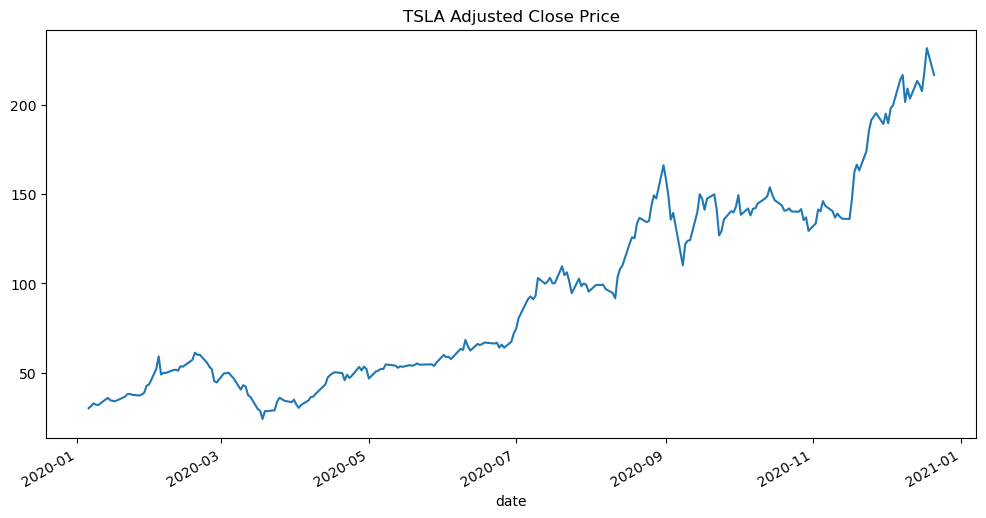

In [67]:
series_tsla = df_tsla.set_index('date')['adj_close'].dropna()
series_tsla.plot(title='TSLA Adjusted Close Price', figsize=(12,6))
plt.show()

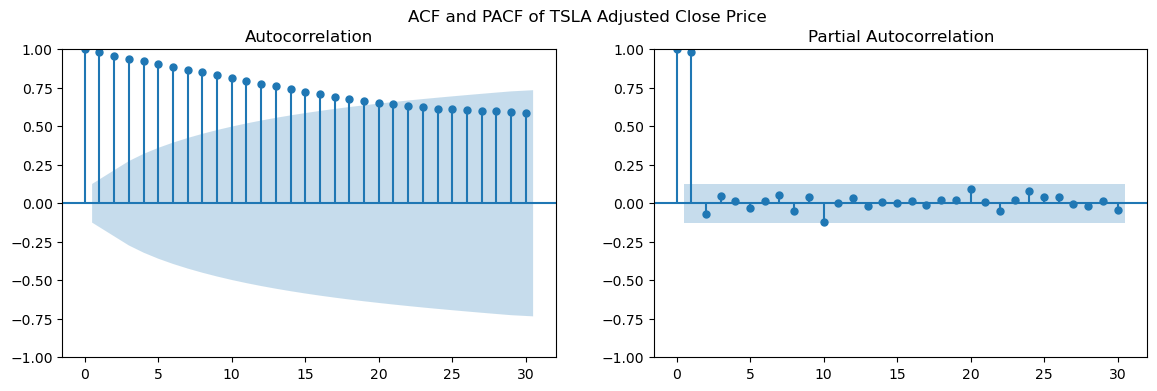

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(series_tsla, lags=30, ax=axes[0])
plot_pacf(series_tsla, lags=30, ax=axes[1])
plt.suptitle('ACF and PACF of TSLA Adjusted Close Price')
plt.show()

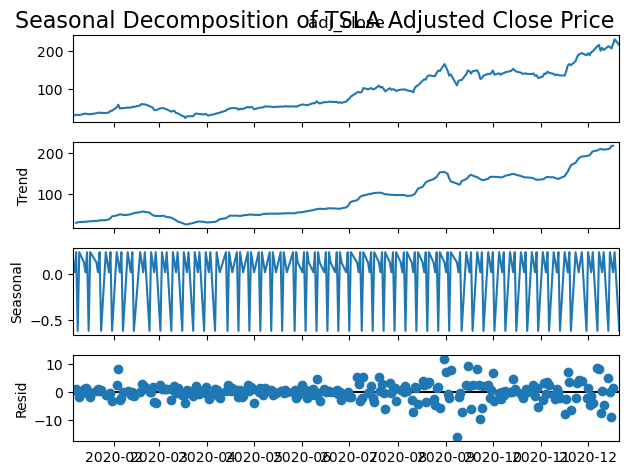

In [69]:
result = seasonal_decompose(series_tsla, model='additive', period=5)
result.plot()
plt.suptitle('Seasonal Decomposition of TSLA Adjusted Close Price', fontsize=16)
plt.show()

In [70]:
diff_series_tsla = df_tsla['adj_close_diff'].dropna()
adf_result_diff_tsla = adfuller(diff_series_tsla)
print(f"ADF Statistic (differenced): {adf_result_diff_tsla[0]:.4f}")
print(f"p-value (differenced): {adf_result_diff_tsla[1]:.4f}")

if adf_result_diff_tsla[1] < 0.05:
    print("Series is stationary after differencing.")
else:
    print("Series is still not stationary after differencing.")

ADF Statistic (differenced): -16.1944
p-value (differenced): 0.0000
Series is stationary after differencing.


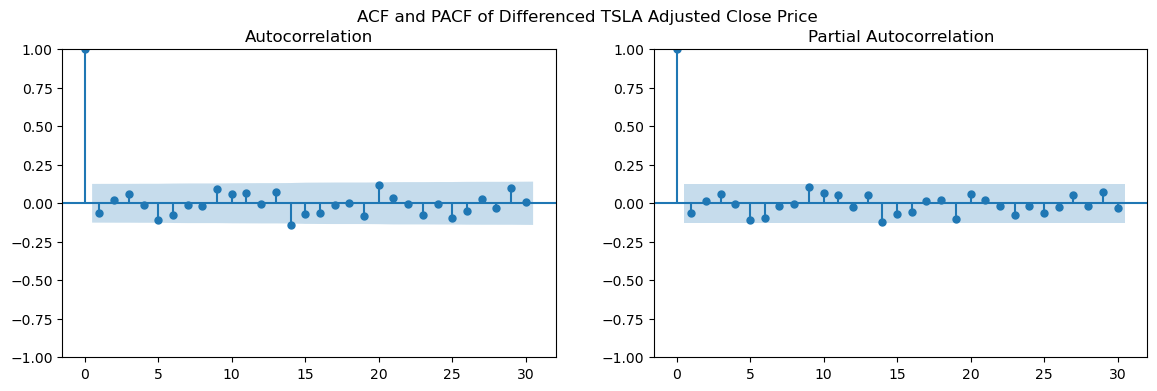

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(diff_series_tsla, lags=30, ax=axes[0])
plot_pacf(diff_series_tsla, lags=30, ax=axes[1])
plt.suptitle('ACF and PACF of Differenced TSLA Adjusted Close Price')
plt.show()

In [72]:
df_tsla_model = df_tsla.dropna(subset=['adj_close_diff', 'sentiment'])

model_tsla = SARIMAX(
    df_tsla_model['adj_close_diff'],
    exog=df_tsla_model[['sentiment']],
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_tsla = model_tsla.fit(disp=False)

last_sentiment_tsla = df_tsla_model['sentiment'].iloc[-1]
future_sentiment_tsla = pd.DataFrame({'sentiment': [last_sentiment_tsla] * 7})
forecast_diff_tsla = results_tsla.get_forecast(steps=7, exog=future_sentiment_tsla)

last_adj_close_tsla = df_tsla['adj_close'].iloc[-1]
forecast_adj_close_tsla = last_adj_close_tsla + forecast_diff_tsla.predicted_mean.cumsum()

print(f"\nTSLA Forecasted Adjusted Close Prices Based on Sentiment:")
print(f"Day 1: {forecast_adj_close_tsla.iloc[0]:.2f}")
print(f"Day 3: {forecast_adj_close_tsla.iloc[2]:.2f}")
print(f"Day 7: {forecast_adj_close_tsla.iloc[6]:.2f}")


TSLA Forecasted Adjusted Close Prices Based on Sentiment:
Day 1: 218.93
Day 3: 221.15
Day 7: 225.92


In [73]:
forecast_dates_tsla = pd.date_range(start=df_tsla['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_tsla['date'],
    y=df_tsla['adj_close'],
    mode='lines',
    name='Historical Adj Close',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast_dates_tsla,
    y=forecast_adj_close_tsla,
    mode='lines+markers',
    name='Forecasted Adj Close (7 days)',
    line=dict(color='orange')
))

fig.update_layout(
    title='TSLA Adjusted Close Price Forecast',
    xaxis_title='Date',
    yaxis_title='Adjusted Close Price',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

In [74]:
print(results_tsla.summary())

                               SARIMAX Results                                
Dep. Variable:         adj_close_diff   No. Observations:                  243
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -748.014
Date:                Fri, 23 May 2025   AIC                           1504.028
Time:                        23:37:32   BIC                           1517.967
Sample:                             0   HQIC                          1509.644
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment      3.9334      2.243      1.753      0.080      -0.463       8.330
ar.L1         -0.1749      0.779     -0.225      0.822      -1.701       1.351
ma.L1          0.1107      0.784      0.141      0.8

In [75]:
SEQ_LEN = 20
FEATURE_COLS = ['adj_close', 'sentiment']
TARGETS = ['close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7']

In [76]:
forecast_results = {}
performance_results = {}

In [77]:
def create_sequences(data, seq_len, feature_cols, target_cols):
    X, y = [], []
    for i in range(len(data) - seq_len):
        seq_x = data.iloc[i:i+seq_len][feature_cols].values
        seq_y = data.iloc[i+seq_len][target_cols].values
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

scalers = {}
tickers = mer_df['ticker'].unique()
for ticker in tickers:
    df_ticker = mer_df[mer_df['ticker'] == ticker].sort_values('date').reset_index(drop=True)
    df_ticker = df_ticker.dropna(subset=TARGETS)

    scaler = MinMaxScaler()
    data_to_scale = df_ticker[FEATURE_COLS + TARGETS]
    scaled_data = scaler.fit_transform(data_to_scale)

    scaled_df = pd.DataFrame(scaled_data, columns=FEATURE_COLS + TARGETS)

    X, y = create_sequences(scaled_df, SEQ_LEN, FEATURE_COLS, TARGETS)

    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(SEQ_LEN, len(FEATURE_COLS))),
        Dense(len(TARGETS))  
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)

    y_pred_inv = scaler.inverse_transform(
        np.hstack([np.zeros((len(y_pred), len(FEATURE_COLS))), y_pred])
    )[:, -len(TARGETS):]

    y_test_inv = scaler.inverse_transform(
        np.hstack([np.zeros((len(y_test), len(FEATURE_COLS))), y_test])
    )[:, -len(TARGETS):]

    last_forecast_scaled = model.predict(X_test[-1].reshape(1, SEQ_LEN, len(FEATURE_COLS)))
    last_forecast = scaler.inverse_transform(
        np.hstack([np.zeros((1, len(FEATURE_COLS))), last_forecast_scaled])
    )[:, -len(TARGETS):][0]

    forecast_results[ticker] = last_forecast

    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv, multioutput='raw_values'))
    mae = mean_absolute_error(y_test_inv, y_pred_inv, multioutput='raw_values')

    performance_results[ticker] = {
        'rmse_day1': rmse[0],
        'rmse_day3': rmse[1],
        'rmse_day7': rmse[2],
        'mae_day1': mae[0],
        'mae_day3': mae[1],
        'mae_day7': mae[2],
    }

print("Forecasts for next days (day 1, day 3, day 7):")
for ticker, forecast in forecast_results.items():
    print(f"{ticker}: Day 1: {forecast[0]:.2f}, Day 3: {forecast[1]:.2f}, Day 7: {forecast[2]:.2f}")

print("\nModel performance (RMSE and MAE):")
performance_df = pd.DataFrame(performance_results).T
print(performance_df)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EE617FE480> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━

In [78]:
fig = make_subplots(rows=len(tickers), cols=1,
                    subplot_titles=[f"{t} Forecast vs Actual" for t in tickers],
                    shared_xaxes=False)

for i, ticker in enumerate(tickers, start=1):
    df_ticker = mer_df[mer_df['ticker'] == ticker].sort_values('date').reset_index(drop=True).dropna(subset=TARGETS)
    scaler = MinMaxScaler()
    data_to_scale = df_ticker[FEATURE_COLS + TARGETS]
    scaled_data = scaler.fit_transform(data_to_scale)
    scaled_df = pd.DataFrame(scaled_data, columns=FEATURE_COLS + TARGETS)
    X, y = create_sequences(scaled_df, SEQ_LEN, FEATURE_COLS, TARGETS)
    split_idx = int(0.8 * len(X))
    X_test = X[split_idx:]
    y_test = y[split_idx:]

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(SEQ_LEN, len(FEATURE_COLS))),
        Dense(len(TARGETS))
    ])
    model.compile(optimizer='adam', loss='mse')
    
    y_test_inv = scaler.inverse_transform(
        np.hstack([np.zeros((len(y_test), len(FEATURE_COLS))), y_test])
    )[:, -len(TARGETS):]

    actual = y_test_inv[-10:]
    predicted = np.tile(forecast_results[ticker], (10,1))

    days = ['Day 1', 'Day 3', 'Day 7']
    for j in range(len(TARGETS)):
        fig.add_trace(go.Scatter(
            y=actual[:, j],
            x=list(range(len(actual))),
            mode='lines+markers',
            name=f"{ticker} Actual {days[j]}",
            legendgroup=ticker,
            line=dict(dash='solid')
        ), row=i, col=1)

        fig.add_trace(go.Scatter(
            y=predicted[:, j],
            x=list(range(len(predicted))),
            mode='lines+markers',
            name=f"{ticker} Predicted {days[j]}",
            legendgroup=ticker,
            line=dict(dash='dash')
        ), row=i, col=1)

fig.update_layout(height=300*len(tickers), width=900, title_text="LSTM Forecast vs Actual Prices per Ticker")
fig.show()

In [95]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from dash.dependencies import Input as DashInput, Output


In [79]:
df = mer_df.copy()
df = df[['ticker', 'date', 'adj_close', 'sentiment', 'close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7']]
df = df.sort_values(['ticker', 'date'])
tickers = df['ticker'].unique()

In [80]:
def create_sequences(data, seq_len=20):
    X, y1, y3, y7 = [], [], [], []
    for i in range(len(data) - seq_len):
        seq_x = data.iloc[i:i+seq_len][['adj_close', 'sentiment']].values
        X.append(seq_x)
        y1.append(data.iloc[i+seq_len]['close_t_plus_1'])
        y3.append(data.iloc[i+seq_len]['close_t_plus_3'])
        y7.append(data.iloc[i+seq_len]['close_t_plus_7'])
    return np.array(X), np.array(y1), np.array(y3), np.array(y7)

In [88]:
SEQ_LEN = 20
results = {}

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df_t = df[df['ticker'] == ticker].reset_index(drop=True)
    
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    features = df_t[['adj_close', 'sentiment']]
    features_scaled = feature_scaler.fit_transform(features)
    
    targets = df_t[['close_t_plus_1', 'close_t_plus_3', 'close_t_plus_7']]
    targets_scaled = target_scaler.fit_transform(targets)
    
    scaled_df = pd.DataFrame(features_scaled, columns=['adj_close', 'sentiment'])
    scaled_df['close_t_plus_1'] = targets_scaled[:, 0]
    scaled_df['close_t_plus_3'] = targets_scaled[:, 1]
    scaled_df['close_t_plus_7'] = targets_scaled[:, 2]
    
    X, y1, y3, y7 = create_sequences(scaled_df, SEQ_LEN)
    
    y = np.vstack((y1, y3, y7)).T  
    
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    inputs = Input(shape=(SEQ_LEN, 2))
    x = LSTM(64, activation='relu')(inputs)
    outputs = Dense(3)(x)  
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)
    
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_true = target_scaler.inverse_transform(y_test)
    
    rmse = np.sqrt(np.mean((y_pred - y_true)**2, axis=0))
    mae = np.mean(np.abs(y_pred - y_true), axis=0)
    
    results[ticker] = {
        'rmse': rmse,
        'mae': mae,
        'y_pred': y_pred,
        'y_true': y_true,
        'dates': df_t['date'].iloc[SEQ_LEN + split_idx:].values
    }
    
    print(f"Forecasts for {ticker} (last test sample):")
    print(f" Day 1: {y_pred[-1, 0]:.2f}, Day 3: {y_pred[-1, 1]:.2f}, Day 7: {y_pred[-1, 2]:.2f}")
    print(f"RMSE: {rmse}, MAE: {mae}")


Processing AAPL...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
Forecasts for AAPL (last test sample):
 Day 1: 125.77, Day 3: 121.85, Day 7: 121.29
RMSE: [3.68621372 5.98438748 7.80482338], MAE: [2.926228   5.17944472 6.45287374]

Processing AMZN...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Forecasts for AMZN (last test sample):
 Day 1: 152.67, Day 3: 151.50, Day 7: 156.72
RMSE: [7.13691809 7.99366159 5.51957845], MAE: [6.15202027 7.11184693 4.67914361]

Processing MSFT...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
Forecasts for MSFT (last test sample):
 Day 1: 217.01, Day 3: 216.82, Day 7: 219.81
RMSE: [5.59855833 5.37591345 4.98235897], MAE: [4.53160807 4.35532192 3.95330302]

Processing NVDA...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Forecasts for NVDA (last test sample):
 Day 1: 138.02, Day 3: 132.51, Day 7: 143.94
RMSE: [10.44121835  5.55075656 17.01051472], MAE: [ 9.427142    4.16122572 16.45645006]

Processing TSLA...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Forecasts for TSLA (last test sampl

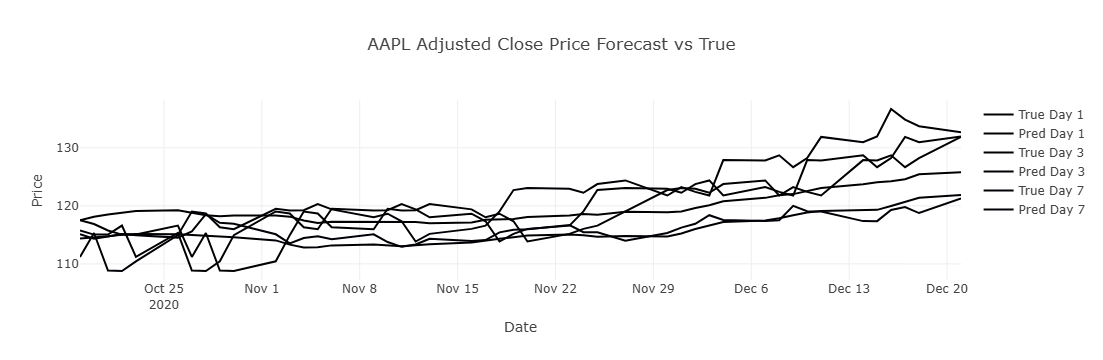

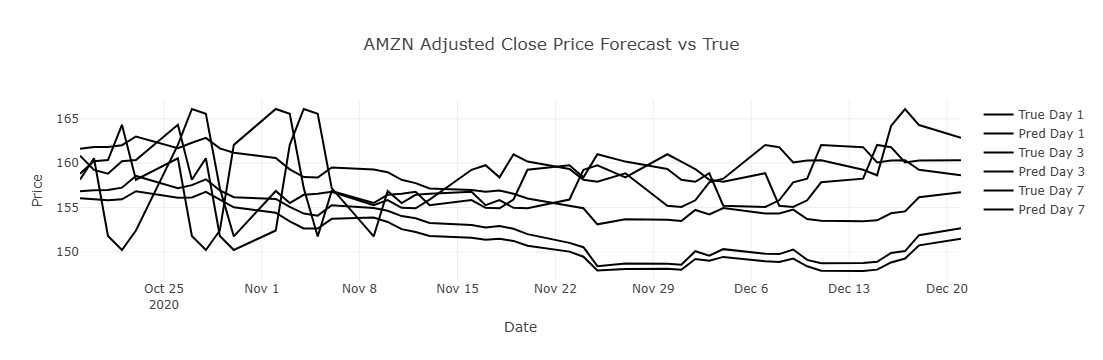

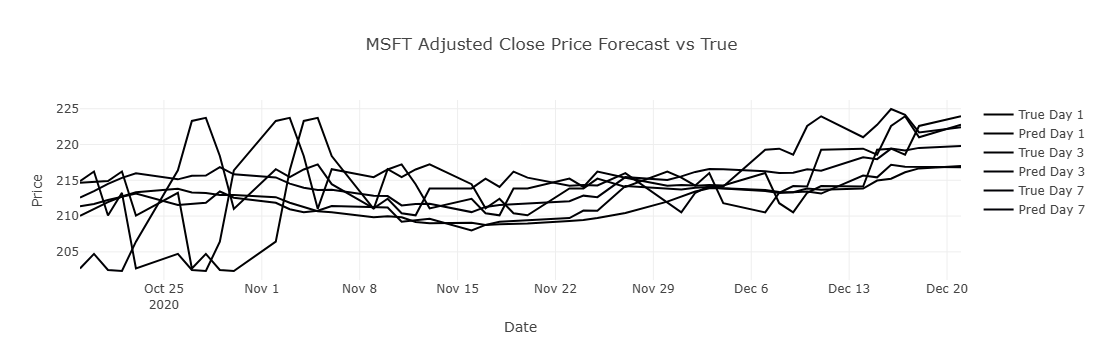

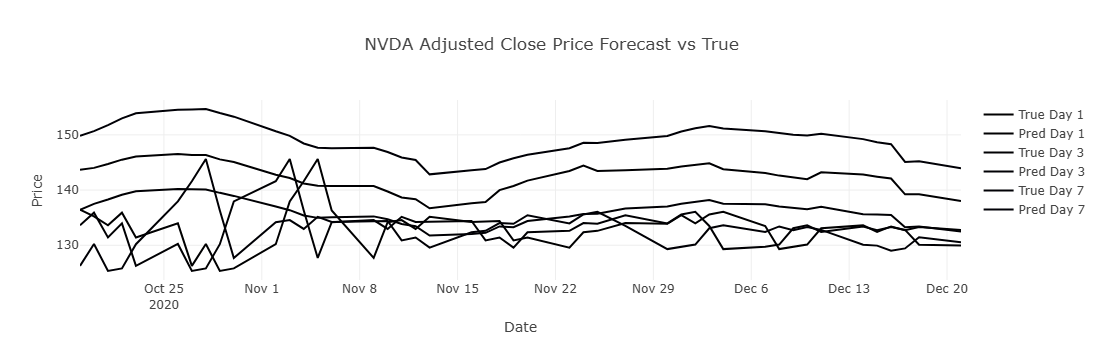

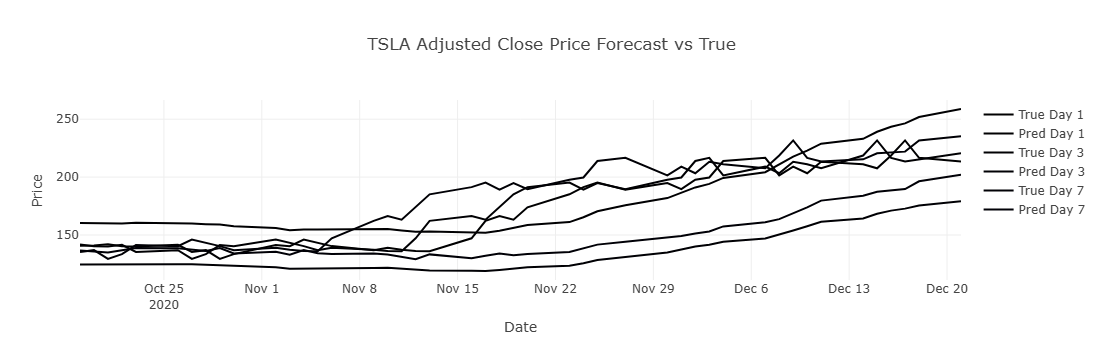

In [89]:
for ticker in tickers:
    res = results[ticker]
    dates = res['dates']
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates, y=res['y_true'][:, 0], mode='lines', name='True Day 1'))
    fig.add_trace(go.Scatter(x=dates, y=res['y_pred'][:, 0], mode='lines', name='Pred Day 1'))
    
    fig.add_trace(go.Scatter(x=dates, y=res['y_true'][:, 1], mode='lines', name='True Day 3'))
    fig.add_trace(go.Scatter(x=dates, y=res['y_pred'][:, 1], mode='lines', name='Pred Day 3'))
    
    fig.add_trace(go.Scatter(x=dates, y=res['y_true'][:, 2], mode='lines', name='True Day 7'))
    fig.add_trace(go.Scatter(x=dates, y=res['y_pred'][:, 2], mode='lines', name='Pred Day 7'))
    
    fig.update_layout(title=f"{ticker} Adjusted Close Price Forecast vs True",
                      xaxis_title="Date", yaxis_title="Price")
    fig.show()

In [99]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Stock Price Dashboard", style={'textAlign': 'center'}),
    
    html.Div([
        html.Label("Select Ticker:"),
        dcc.Dropdown(
            id='ticker-dropdown',
            options=[{'label': t, 'value': t} for t in mer_df['ticker'].unique()],
            value=mer_df['ticker'].unique()[0]
        )
    ], style={'width': '300px', 'margin': 'auto'}),
    
    dcc.Graph(id='adj-close-plot'),
    dcc.Graph(id='close-ma-plot'),
    dcc.Graph(id='forecast-plot'),
    dcc.Graph(id='forecast-vs-actual-plot')
])

@app.callback(
    Output('adj-close-plot', 'figure'),
    DashInput('ticker-dropdown', 'value')
)
def update_adj_close_plot(selected_ticker):
    filtered_df = mer_df[mer_df['ticker'] == selected_ticker]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=filtered_df['date'],
        y=filtered_df['adj_close'],
        mode='lines',
        name='Adjusted Close'
    ))
    fig.update_layout(
        title=f'{selected_ticker} Adjusted Closing Prices Over Time',
        xaxis_title='Date',
        yaxis_title='Adjusted Close',
        template='plotly_white'
    )
    return fig

@app.callback(
    Output('close-ma-plot', 'figure'),
    DashInput('ticker-dropdown', 'value')
)
def update_close_ma_plot(selected_ticker):
    df = mer_df[mer_df['ticker'] == selected_ticker]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['date'], y=df['close'], mode='lines', name='Close', line=dict(color='blue'), opacity=0.4))
    fig.add_trace(go.Scatter(x=df['date'], y=df['ma_5'], mode='lines', name='MA 5', line=dict(color='orange', dash='dash')))
    fig.update_layout(
        title=f'{selected_ticker} Close Price and 5-Day Moving Average',
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white'
    )
    return fig

@app.callback(
    Output('forecast-plot', 'figure'),
    DashInput('ticker-dropdown', 'value')
)
def update_forecast_plot(selected_ticker):
    df_ticker = mer_df[mer_df['ticker'] == selected_ticker].sort_values('date').reset_index(drop=True)
    
    forecast_map = {
        'MSFT': forecast_adj_close_msft,
        'NVDA': forecast_adj_close_nvda,
        'TSLA': forecast_adj_close_tsla,
    }
    forecast_data = forecast_map.get(selected_ticker, forecast_adj_close)
    
    forecast_dates = pd.date_range(start=df_ticker['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker['adj_close'], mode='lines', name='Historical Adj Close', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_data, mode='lines+markers', name='Forecasted Adj Close', line=dict(color='orange')))
    
    fig.update_layout(
        title=f'{selected_ticker} Adjusted Close Price Forecast',
        xaxis_title='Date',
        yaxis_title='Adjusted Close Price',
        template='plotly_white'
    )
    return fig

@app.callback(
    Output('forecast-vs-actual-plot', 'figure'),
    DashInput('ticker-dropdown', 'value')
)
def update_forecast_vs_actual(selected_ticker):
    res = results[selected_ticker]
    dates = res['dates']
    y_true = res['y_true']
    y_pred = res['y_pred']

    fig = go.Figure()
    days = ['Day 1', 'Day 3', 'Day 7']
    colors = ['blue', 'green', 'red']
    for i, day in enumerate(days):
        fig.add_trace(go.Scatter(x=dates, y=y_true[:, i], mode='lines', name=f'True {day}', line=dict(color=colors[i], dash='solid')))
        fig.add_trace(go.Scatter(x=dates, y=y_pred[:, i], mode='lines', name=f'Predicted {day}', line=dict(color=colors[i], dash='dash')))
    
    fig.update_layout(
        title=f"{selected_ticker} Adjusted Close Price Forecast vs True",
        xaxis_title="Date",
        yaxis_title="Price",
        template='plotly_white'
    )
    return fig

if __name__ == '__main__':
    app.run(debug=True)
